In [99]:
import os
from typing import Optional
import numpy as np
import pytorch_lightning as pl
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, Normalize


In [3]:
PATH_DATA = "/home/ubuntu/datasets/segment_car_plate/data/train"

In [12]:
images = list(
    {
        tuple(x for x in fn.split(".") if x != "mask") 
        for fn in os.listdir(PATH_DATA)
    }
)
n_img = len(images)

In [13]:
train, val, test = np.split(
    images, (int(n_img*0.6), int(n_img*0.8))
)

In [15]:
assert n_img == len(train)+len(val) + len(test)

In [63]:
class DetectionDataset(Dataset):
    def __init__(self, data_path, config, transforms=None,):
        super(DetectionDataset, self).__init__()
        self.data_path = data_path
        self.transforms = transforms
        self.images = [
            os.path.join(self.data_path,f"{name}.{ext}") for name, ext in config
        ]
        self.masks = [
            os.path.join(self.data_path,f"{name}.mask.{ext}") for name, ext in config
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx]).astype(np.float32) / 255.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
        item = dict(image=image, mask=mask)

        if self.transforms is not None:
            item = self.transforms(**item)

        item["mask"] = item["mask"][None, :, :]

        return item

In [120]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        split_proportions = (0.6, 0.8),
        batch_size = 32,
        image_size=256,
        seed = None,
    ):
        self.data_dir = data_dir
        self.split_proportions = split_proportions
        self.images = list(
            {
                tuple(x for x in fn.split(".") if x != "mask") 
                for fn in os.listdir(data_dir)
            }
        )
        self.n_img = len(self.images)
        self.batch_size = batch_size
        self.image_size = image_size
        self.transforms = self.get_transforms(image_size=self.image_size)
        
    @staticmethod
    def get_transforms(image_size: int = 256):
        return Compose([
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25), max_pixel_value=1.),
            Resize(height=image_size, width=image_size, ),
            ToTensorV2(),
        ])

    def setup(self, stage: Optional[str] = None):
        if stage == "3" or stage is None:
            print(self.images[:5])
            print(tuple(int(n_img*x) for x in self.split_proportions))
            self.train, self.val, self.test = np.split(
                self.images, 
                tuple(int(n_img*x) for x in self.split_proportions)
            )
        elif stage == "2":
            self.train, self.val = np.split(
                self.images, tuple(int(n_img*self.split_proportions[0]),)
            )
        elif stage == "1":
            self.train = images        
    
    def train_dataloader(self):
        # train_transforms = get_train_transforms(256)
        ds = DetectionDataset(data_path=self.data_dir, config=self.train, transforms=self.transforms)
        return DataLoader(ds, batch_size=self.batch_size)

    def val_dataloader(self):
        ds = DetectionDataset(data_path=self.data_dir, config=self.val)
        return DataLoader(ds, batch_size=self.batch_size)

    def test_dataloader(self):
        ds = DetectionDataset(data_path=self.data_dir, config=self.test)
        return DataLoader(ds, batch_size=self.batch_size)


In [121]:
data = DataModule(data_dir=PATH_DATA)
data.setup()

dataloader = data.train_dataloader()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


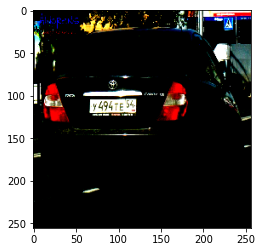

In [123]:
for item in dataloader:
    break
plt.imshow(
    np.transpose(item["image"][0], (1, 2, 0))
)

In [81]:
ds = DetectionDataset(data_path=PATH_DATA, config=images[:5])
item = ds[0]
plt.imshow(item["image"])

In [69]:
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2, Compose, Resize, Normalize


# class Compose(object):

#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, mask):
#         for t in self.transforms:
#             image, mask = t(image, mask)
#         return image, mask


# class Resize(object):
#     def __init__(self, size):
#         self.size = size

#     def __call__(self, image, mask, force_apply=False):
#         image_, mask_ = image.copy(), mask.copy()
#         if image_.shape[0] != self.size[1] or image_.shape[1] != self.size[0]:
#             image_ = cv2.resize(image_, self.size)
#             mask_ = cv2.resize(mask_, self.size)
#         return dict(image=image_, mask=mask_)


# class Normalize(object):
#     def __init__(self, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
#         self.mean = np.asarray(mean).reshape((1, 1, 3)).astype(np.float32)
#         self.std = np.asarray(std).reshape((1, 1, 3)).astype(np.float32)

#     def __call__(self, image, mask):
#         image = (image - self.mean) / self.std
#         return image, mask


# TODO TIP: Is default image size (256) enough for segmentation of car license plates?
def get_train_transforms(image_size):
    return A.Compose([
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25), max_pixel_value=1.),
        Resize(size=(image_size, image_size)),
        ToTensorV2(),
    ])

In [71]:
train_transforms = get_train_transforms(256)